Multiple Centrality Assessment (MCA) is an approach to street network analysis developed by Porta and Latora (2006). It's main aim is to understand the structure of street network of our cities from the perspective of the importance and position of each street/intersection within the whole network as expressed by various centralities. Momepy can do all types of MCA-based centrality analysis as were developed through the years.

The aim of this notebook is to illustrate how to measure different centralities using momepy. For the theoretical background, please refer to the work of Porta et al.

In [1]:
import geopandas as gpd
import momepy
import osmnx as ox
import matplotlib.pyplot as plt

In the ideal case, momepy expects LineString GeoDataFrame containing street network as a starting point. Either we have our own, or we can use osmnx to dowload network from OSM. In this notebook, we will look at Vicenza, Italy.

In [2]:
streets_graph = ox.graph_from_place('Vicenza, Italy', network_type='drive')
streets_graph = ox.project_graph(streets_graph)

Code above dowloaded network from OSM and projected it. At this point, `streets_graph` is networkX Graph object, similar to the one we will use in momepy. In theory, you can use it directly. However, momepy when converting GeoDataFrame to network ensures that all attributes are set and compatible with morphometric functions, so we do recommend saving graph to gdf and let momepy do the conversion back to graph.

In [3]:
edges = ox.save_load.graph_to_gdfs(streets_graph, nodes=False, edges=True,
                                   node_geometry=False, fill_edge_geometry=True)

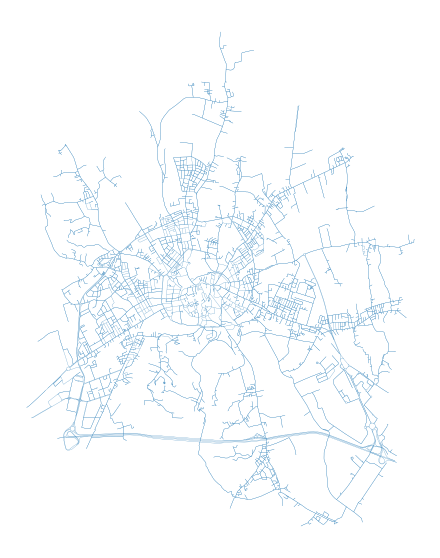

In [4]:
f, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.2)
ax.set_axis_off()
plt.show()

To measure centrality, we have to *convert* gdf to graph. For that, we can choose from two options how to represent street network within graph. First and the most straightforward one is the primal approach (Porta et al., 2006) where street is represented by graph edge and intersection by node.

## Primal graph

We can generate networkX.MultiGraph, which is used within momepy, using `gdf_to_nx`.

In [5]:
primal = momepy.gdf_to_nx(edges, approach='primal')

### Closeness centrality

Closeness centrality could be simplified as average distance to every other node from each node. As such, it can be measured on the whole network (Global Closeness Centrality) or wihtin certain reach only (Local Closeness Centrality). 

#### Local closeness
To measure `local_closeness_centrality` we need to specify radius (how far we should go from each node). We can use topological distance (e.g. 5 steps, then radius=5) or metric distance (e.g. 400 metres) - then radius=400 and distance= lenght of each segment saved as a parameter of each edge. By default, momepy saves length as `mm_len`. 

Weight parameter is used for centrality calculation. Again, we can use metric weight (using the same attribute as above) or no weight (weight=None) at all. Or any other attribute we wish.

In [6]:
primal = momepy.local_closeness_centrality(primal, radius=400, name='closeness400', distance='mm_len', weight='mm_len')

100%|██████████| 4075/4075 [00:09<00:00, 451.13it/s]


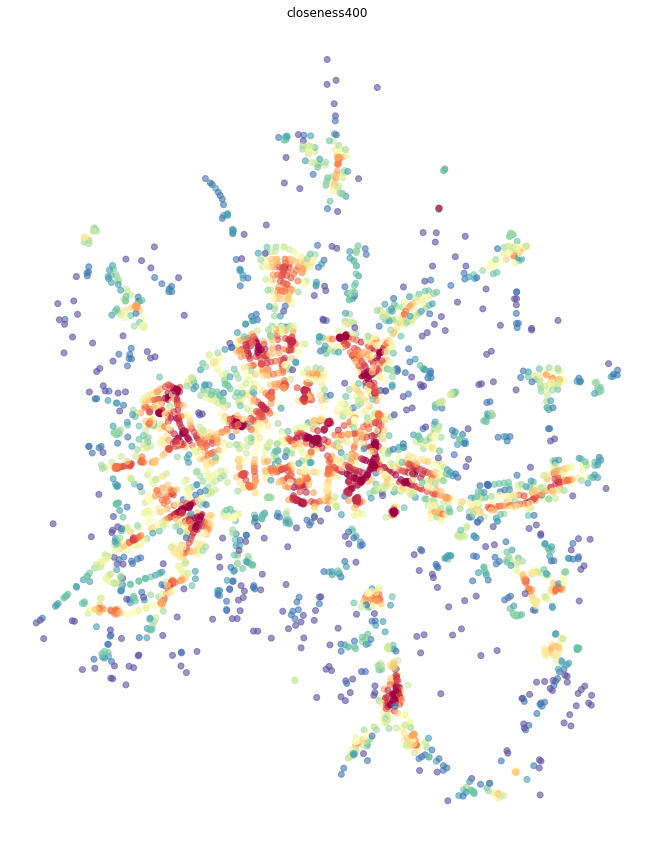

In [7]:
nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='closeness400', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness400')
plt.show()

#### Global closeness

Global closeness centrality is a bit simpler as we do not have to specify radius and distance, the rest remains the same.

In [8]:
primal = momepy.closeness_centrality(primal, name='closeness_global', weight='mm_len')

**Note**: Computing global centrality on larger network can take a while to compute, be patient.

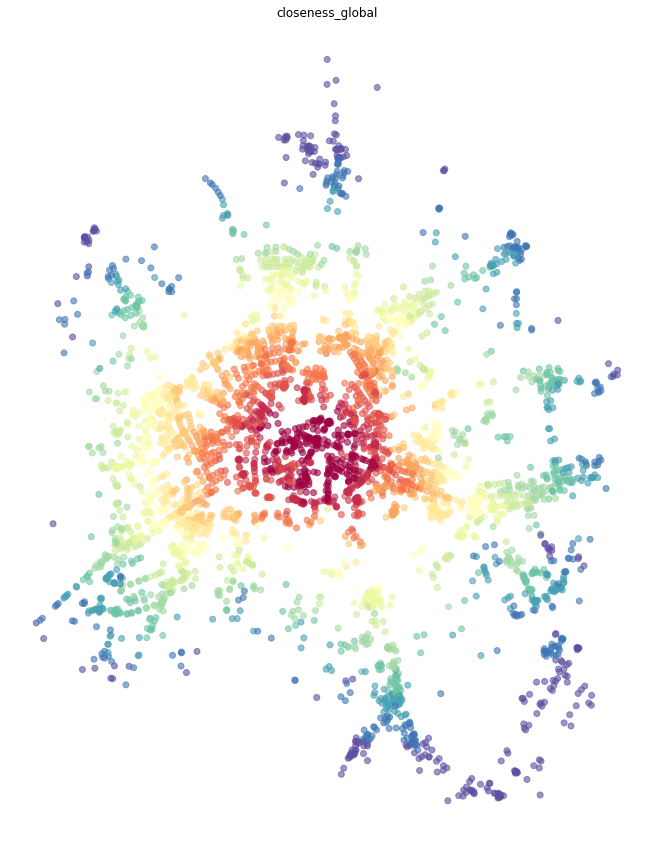

In [9]:
nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='closeness_global', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness_global')
plt.show()

### Betweenness

Betweenness centrality measures the importance of each node or edge for the travelling along the network. It measures how many times is each node/edge used if we walk using the shortest paths from each node to every other. 

We have two options how to measure betweenness on primal graph - on nodes or on edges.

#### Node-based
Node-based betweenness, as name suggests, measures betweennes of each node - how many times we would walk through node.

In [10]:
primal = momepy.betweenness_centrality(primal, name='betweenness_metric_n', mode='nodes', weight='mm_len')

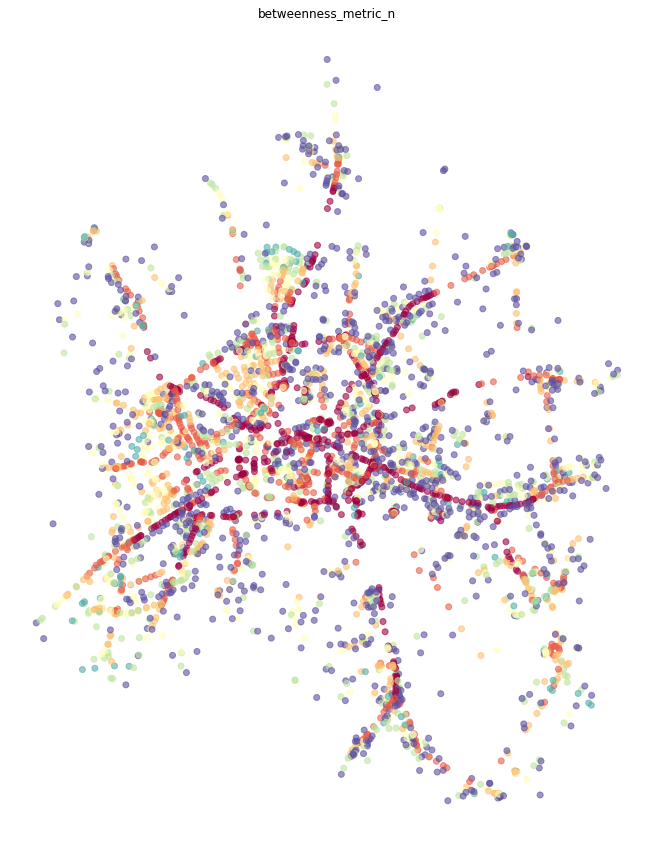

In [20]:
nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=7, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweenness_metric_n')
plt.show()

#### Edge-based

Edge-based betweenness does the same but for edges. How many times we go through each edge (street).

In [12]:
primal = momepy.betweenness_centrality(primal, name='betweenness_metric_e', mode='edges', weight='mm_len')

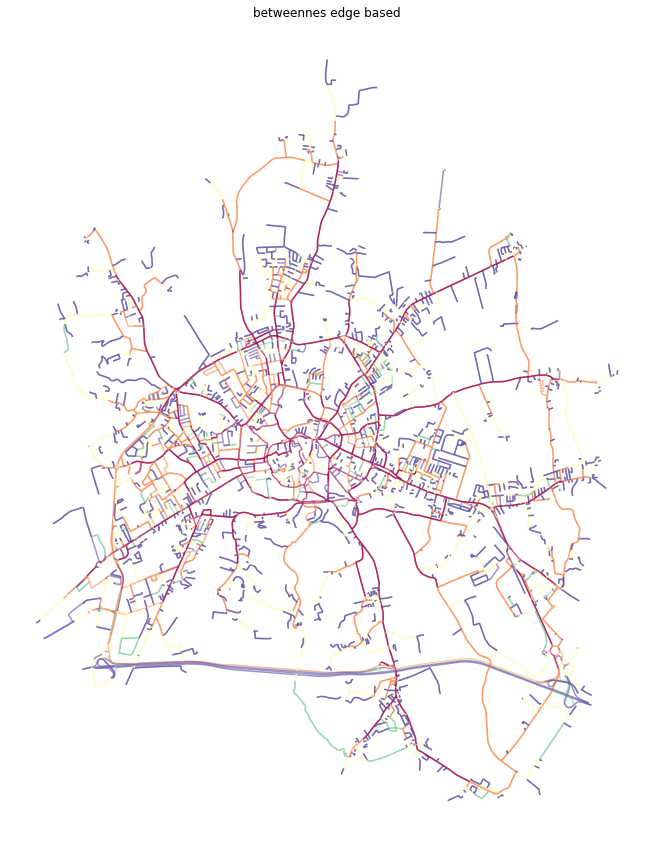

In [25]:
primal_gdf = momepy.nx_to_gdf(primal, points=False)
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='betweenness_metric_e', cmap='Spectral_r', scheme='quantiles', alpha=0.6)
ax.set_axis_off()
ax.set_title('betweennes edge based')
plt.show()

### Straightness

While both closeness and betweenness are generally used in many applications of network analysis, straightness centrality is specific to street networks as it requires geographical element. It is measured as a ratio between real and Euclidean distance while waking from each node to every other.

In [26]:
primal = momepy.straightness_centrality(primal)

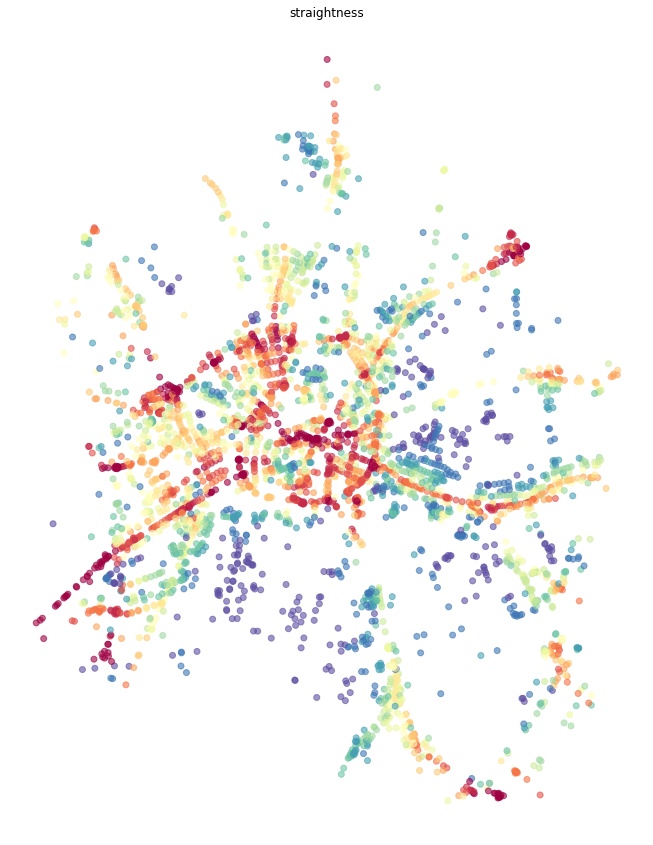

In [27]:
nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('straightness')
plt.show()

### Node values averaged onto edges

In some cases, it is easier to understand centrality results if they are attached to street segments, rather than intersections. We can do an approximation using the mean value attached to start and end node of each edge.

In [28]:
momepy.mean_nodes(primal, 'straightness')
momepy.mean_nodes(primal, 'closeness400')
momepy.mean_nodes(primal, 'closeness_global')
momepy.mean_nodes(primal, 'betweenness_metric_n')

100%|██████████| 8550/8550 [00:00<00:00, 153788.39it/s]


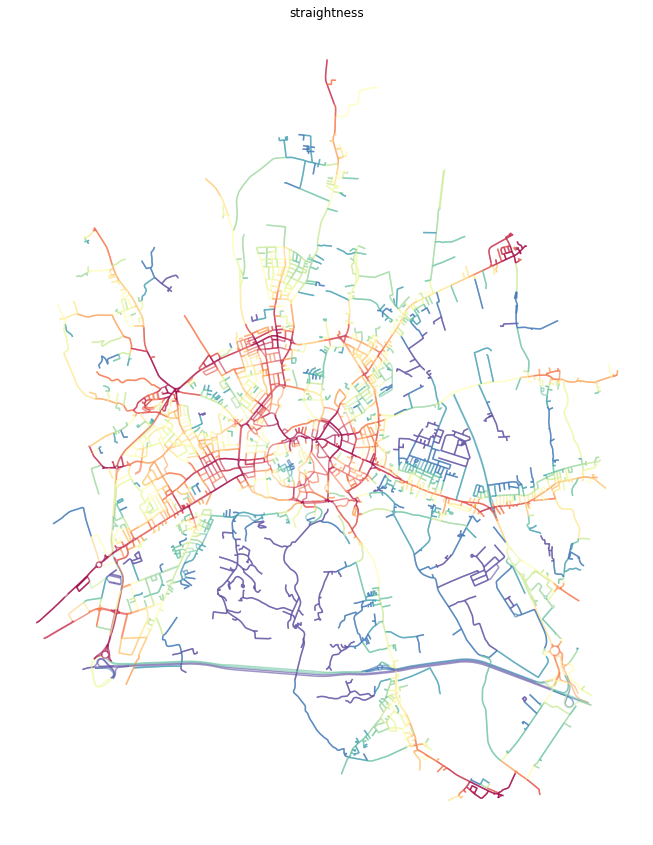

In [29]:
primal_gdf = momepy.nx_to_gdf(primal, points=False)

f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('straightness')
plt.show()

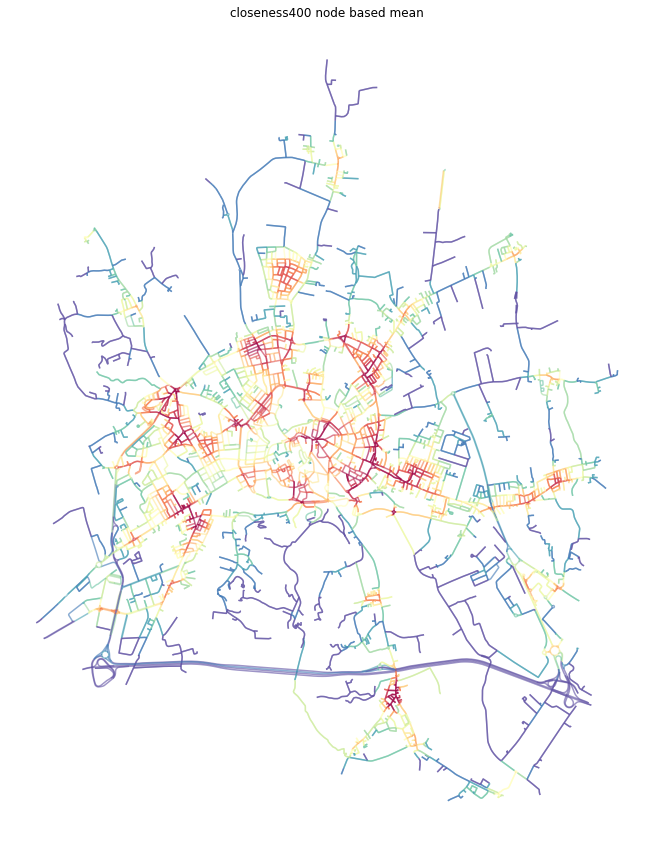

In [30]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='closeness400', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness400 node based mean')
plt.show()

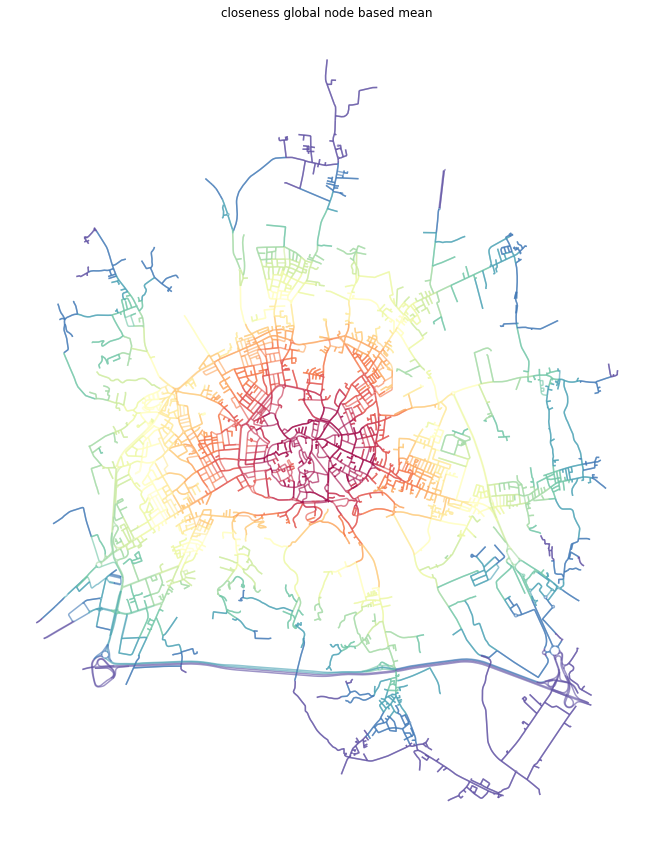

In [31]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='closeness_global', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness global node based mean')
plt.show()

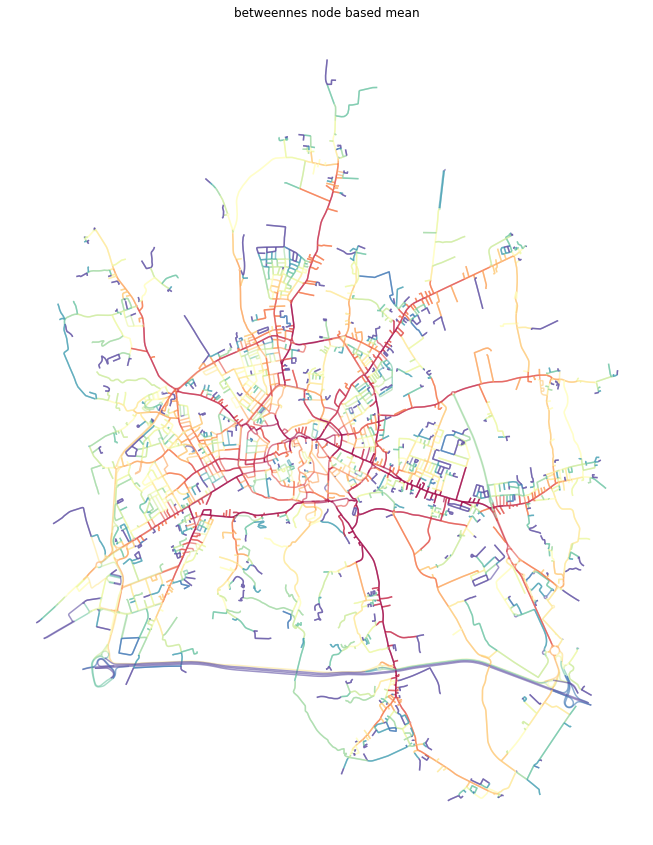

In [32]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweennes node based mean')
plt.show()

Once we have finished our network analysis on primal graph, we can save both nodes and edges back to GeoDataFrames.

In [33]:
nodes, edges_p = momepy.nx_to_gdf(primal)

### Topological vs metric distances

Centrality can be measure topologically (ignoring physical lenght of street segments) or metrically. Moreover, in the case of local centrality, local subgraph can be also defined topologically and metrically. In the end, you have four options how to measure centralilty, illustrated on `local_betweenness_centrality`:

In [ ]:
# topologically defined subgraph (5 steps) and topologically measured shortest path in betweenness
local_betweenness_centrality(graph, radius=5, name='betweenness', distance=None, weight=None)

# topologically defined subgraph (5 steps) and metrically measured shortest path in betweenness
local_betweenness_centrality(graph, radius=5, name='betweenness', distance=None, weight='edge_length')

# metrically defined subgraph (800 meters) and topologically measured shortest path in betweenness
local_betweenness_centrality(graph, radius=800, name='betweenness', distance='edge_length', weight=None)

# metrically defined subgraph (800 meters) and metrically measured shortest path in betweenness
local_betweenness_centrality(graph, radius=800, name='betweenness', distance='edge_length', weight='edge_length')

## Dual graph

Dual graph is a bit more complicated concept as it represents street segments as nodes while intersections as edges connecting nodes. The geographical distance is lost as edges are of virtually no length, but we can capture the angle between each connected streets. Momepy does that by default, using angles between lines connecting start and end points of each segment. Hence, we can measure angular centrality.

**Note**: Dual graphs have naturally much more connections than primal ones, so computation of centrality on dual graph takes longer.

In [34]:
dual = momepy.gdf_to_nx(edges, approach='dual')

### Angular closeness

The situation with closeness is similar to the one done on primal graph. We can again do global and local closeness.

#### Local
Difference is that we do not have geographic distance, so we can limit closeness topologically or by another attribute (line angle). Example below uses topological distance of 5 steps.

In [35]:
dual = momepy.local_closeness_centrality(dual, radius=5, name='angcloseness400', weight='angle')

100%|██████████| 6003/6003 [00:24<00:00, 244.58it/s]


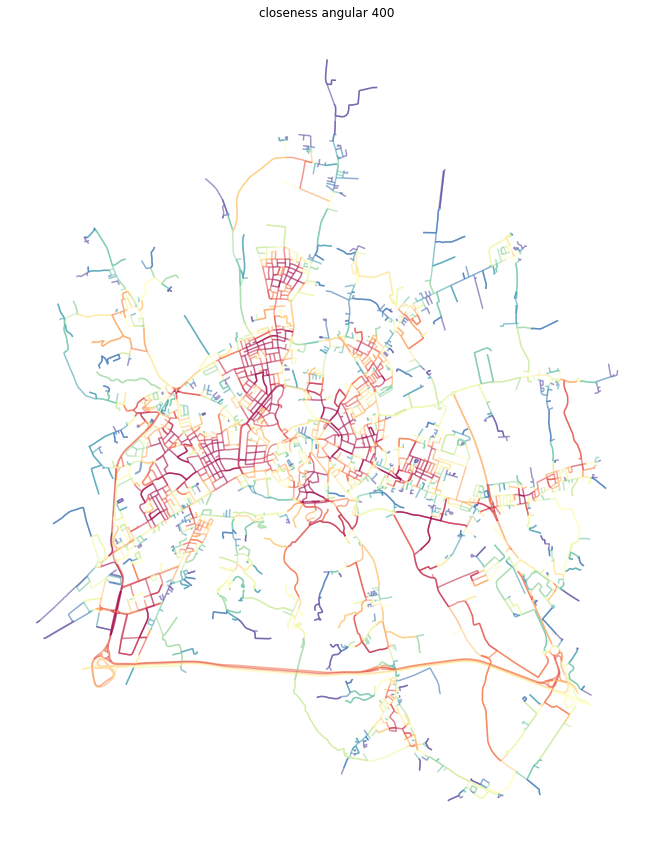

In [37]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)

f, ax = plt.subplots(figsize=(15, 15))
dual_gdf.plot(ax=ax, column='angcloseness400', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness angular 400')
plt.show()

#### Global

Global angular closeness is then straightforward.

In [38]:
dual = momepy.closeness_centrality(dual, name='closeness_global_ang', weight='angle')

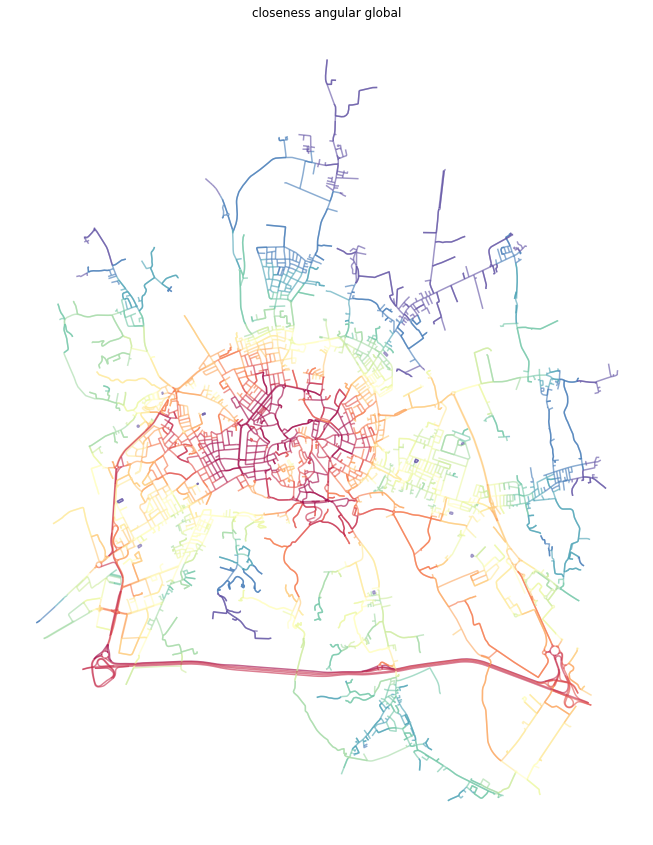

In [39]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)
f, ax = plt.subplots(figsize=(15, 15))
dual_gdf.plot(ax=ax, column='closeness_global_ang', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness angular global')
plt.show()

### Angular betweenness
The last option momepy offers is angular betweenness. Just keep in mind, that nodes and edges are not representing the same concepts and it does not make much sense to measure angular betweennes on edges. Moreover, `nx_to_gdf` converts dual graph to LineString gdf only.

In [40]:
dual = momepy.betweenness_centrality(dual, name='angbetweenness', mode='nodes', weight='angle')

/Users/martin/anaconda3/envs/momepy_guide/lib/python3.7/site-packages/mapclassify/classifiers.py:320: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/martin/anaconda3/envs/momepy_guide/lib/python3.7/site-packages/mapclassify/classifiers.py:320: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k


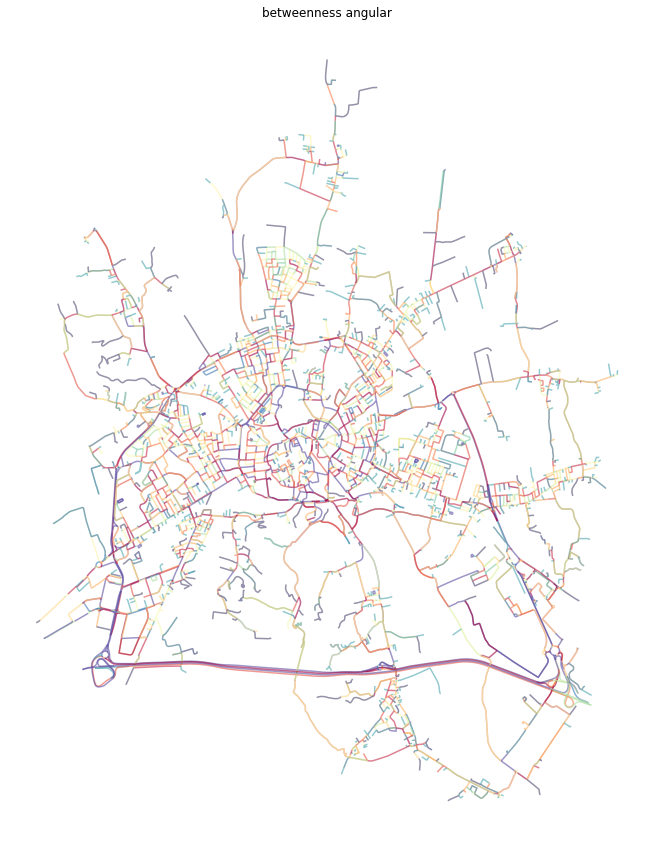

In [42]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)
f, ax = plt.subplots(figsize=(15, 15))
dual_gdf.plot(ax=ax, column='angbetweenness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweenness angular')
plt.show()

In [43]:
edges_d = momepy.nx_to_gdf(dual)